<a href="https://colab.research.google.com/github/JonathanCornish/Portfolio_Monte_Carlo/blob/master/Portfolio_Monte_Carlo_v02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monte Carlo simulation for portfolio returns & drawdowns given various levels of leverage, concentration, vol etc:

Important assumptions in this model include:


*   All positions are uncorrelated to one another
*   Expected return is constant over time
*   Expected volatility is constant over time
*   Expected vol & expected returns are each the same for every stock in the long portfolio
*   Expected vol & expected returns are each the same for every stock in the short portfolio
*   Daily rebalancing occurs for all the stocks in the long & short portfolios such that the long and short portfolios are each equally-weighted at the start of each day
*   Daily rebalancing also occurs at the portfolio level at the start of each day so the gross exposure % is the same every day
*   It's assumed that there's neither fees nor rebalancing costs
*   This model assumes a bell curve for return distributions, but in real life there are fat tails. This analysis is thus inherently limited and misses things like correlations, unexpected tail events like COVID, etc
*   This analysis doesn't let you go over 100% net (because I haven't factored in a cost of margin debt)
*   This analysis assumes there's no cost of borrow on shorts
*   This analysis assumes there's no yield on cash held



In [131]:
## Let's try to make money without getting our heads blown off.
## Import the required libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import random
import pandas as pd

In [132]:
# some model inputs we're hardcoding in:
beg_account_value = 1000 # we'll assume that the account begins with $1,000 in it...
num_days = 252 # we'll run this for 252 trading days i.e. 1 year

In [133]:
# create a function that plots portfolio return over time. 
# the imaginary long portfolio is designated a random return for the daily period, using np.random.normal(mean, std_dev). Same thing for the short portfolio
# the imaginary long portfolio and short portfolio's returns are summed each period to generate the daily return.
# be sure to type all of the inputs into this formula in decimal places...

# This function takes the following arguments:
#0. num_simulations = the number of simulations we're going to run
#1. long_daily_std_dev = annual standard deviation of each long position (they're assumed to all be the same)
#2. short_daily_std_dev = same thing as above but for short positions
#3. num_long_positions = the number of long positions in the long book. I assume they're each equally weighted...
#4. num_short_positions = same as above but for short positions
#5. long_ann_expected_ret = expected annual return of the long positions. They're each expected to have the same long-term expected return, but with differing returns each day based on the long_cor
#6. short_ann_expected_ret = same as above but for short positions. This number is the expected return of the stocks that you're short. So, if you're short AAPL and AAPL has expected return of 5%, put 0.05 (not -0.005) !!
#7. long_exp = long exposure. E.g. 1.2 means 120% long
#8. short_exp = same as above but for short exposure. Keep this as a positive number i.e. not negative

def portfolio_return(num_simulations, long_daily_std_dev, short_daily_std_dev, num_long_positions, num_short_positions, long_ann_expected_ret, short_ann_expected_ret, long_exp, short_exp):
    for sim in range(num_simulations):

      # create a list to keep track of the account value each day as we run through the simulation
      account_value = [beg_account_value]

      for day in range(num_days):       
        # create two empty lists that we'll use in the following for loop to store the long and short attributions in for each position in the long & short books that day
        # these lists are re-set to being empty each time we enter a new day
        long_attrs = []
        short_attrs = []

        # list comprehension:
        # for each long position in the long portfolio...
        # append to the end of the long_attrs list the attribution of each of these stocks. We assume daily rebalancing at the position and gross exposure level
        # the long_attrs is calculated as the position exposure multipled by the daily return we calculated above for the long portfolio
        # the position exposure = [long exposure divided by number of long positions] * [total account value at the start of the day]
        [long_attrs.append((long_exp / num_long_positions) * account_value[-1] * (1 + np.random.normal(long_ann_expected_ret / 252, long_daily_std_dev))) for long_pos in range(num_long_positions)]        
        
        # list comprehension: for each short position, append the $ notional value of that position to the end of the short_attrs list
        [short_attrs.append((short_exp / num_short_positions) * account_value[-1] * (1 + np.random.normal(short_ann_expected_ret / 252, short_daily_std_dev))) for short_pos in range(num_short_positions)]
        
        # append the end-of-day account value to the list of account values
        if (long_exp - short_exp) < 1:
          # i.e. if net exposure < 100%
          if long_exp < 1:
            # i.e. if long exposure < 100%, remember to add back the cash
            account_value.append(sum(long_attrs) + (1 - long_exp) * account_value[-1] - sum(short_attrs) + short_exp * account_value[-1])
          else:
            account_value.append(sum(long_attrs) - sum(short_attrs) + (short_exp - (long_exp - 1)) * account_value[-1])
        else:
          account_value.append(sum(long_attrs) - sum(short_attrs))

      # reference a data frame called 'simulation_df' and put the list of daily account values into it for that particular simulation
      simulation_df[sim] = account_value

    # increase the default plotsize
    fig, ax = plt.subplots(figsize = (14, 7))
    # format the y axis as dollars
    formatter = ticker.FormatStrFormatter('$%1.0f')
    ax.yaxis.set_major_formatter(formatter)
    # label the axis
    plt.xlabel("Number of days")
    plt.ylabel("Account Value")
    # give the graph a title
    plt.suptitle("Monte Carlo Simulation for Gross HF Returns:")
    # for styling rotate the x axis labels 25 degrees
    plt.xticks(rotation=25)
    # plot it & show the plot!
    plt.plot(simulation_df)
    plt.show()

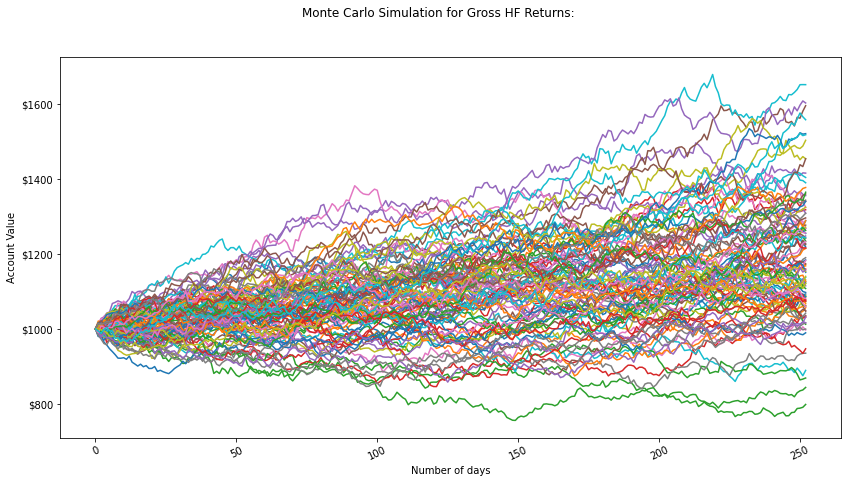

In [142]:
# Run the portfolio returns function & output the graph. The inputs used are the following:
#1. num_simulations = 100
#2. long_daily_std_dev = 2%
#3. short_daily_std_dev = 2%
#4. num_long_positions = 15
#5. num_short_positions = 30
#6. long_ann_expected_ret = 15%
#7. short_ann_expected_ret = 5%
#8. long_exp = 150%
#9. short_exp = 90%

# First we have to create an empty dataframe:
simulation_df = pd.DataFrame()
# Then run the function with the above-specified inputs:
portfolio_return(100, 0.02, 0.02, 15, 30, 0.15, 0.05, 1.5, 0.9)

In [143]:
# Show the first five rows (head) of the table we created when we ran the cell above. 
# The number of columns is equal to the number of simulations specified in the function inputs above.
# We can see that all the columns start at 1000 at time zero, and then change based on our randomly calculated daily returns:
simulation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
1,1002.425883,1006.251647,999.124330,1012.241091,1003.047193,1000.162590,1002.182083,1000.783730,1001.223724,1003.828938,1010.270006,1010.207297,994.399871,1006.394776,1003.324725,990.089313,1010.185002,1007.296104,994.462455,999.265128,1004.194204,998.462836,1003.582634,992.561253,995.481194,990.451293,1014.705030,988.257864,1010.673753,995.388625,1009.464904,998.347553,991.973290,1008.942022,992.474589,996.904327,1005.841322,997.519893,998.779756,985.084076,...,979.567305,985.506029,986.359196,999.319889,1005.879694,1010.821941,1002.457174,997.299788,989.097519,1001.095255,991.106111,997.635177,988.968459,1005.228363,990.596246,994.897977,1000.281110,1004.910222,997.679987,996.660588,994.212325,1006.315760,1002.907417,1012.299409,1008.568659,1008.424353,1000.872693,982.498625,1007.826155,991.397882,1016.251871,1000.810683,998.410380,999.891858,991.446978,1013.735294,989.975966,1014.368702,999.996109,993.529648
2,998.325003,992.276215,1007.618330,1017.047677,1013.987786,986.717321,979.606312,993.869617,1004.859460,1010.844734,1011.088737,1007.581648,995.439190,1015.803226,1003.089314,988.012344,1023.118975,1004.533940,996.610472,990.382760,997.893846,997.083344,1019.491430,993.873970,1002.898378,1001.532570,1011.625067,1001.465380,998.574179,992.748148,1012.770552,998.979634,982.359287,1004.422814,983.660288,981.995653,990.291723,997.978539,989.598509,990.618683,...,978.638057,988.384719,987.669826,1014.700751,1001.206972,1008.870158,991.198276,1004.584226,982.464946,1005.712271,987.239557,1004.018401,995.884659,1014.445277,979.405907,1006.563343,1015.846565,998.361343,996.502472,994.023771,991.893181,1000.096884,1012.860484,1008.522509,1018.415675,1009.714303,1011.172680,972.613341,1009.671807,989.603055,1018.788576,1008.309150,992.135047,1002.224250,977.688734,1021.465536,1007.417151,1012.354491,997.283577,988.401883
3,1006.043448,994.748063,1006.599496,1012.277620,1012.469150,988.210119,976.968488,993.444697,1009.829773,1009.559919,1028.864993,1004.904180,993.445500,1028.413303,999.928256,1001.212084,1009.356198,1009.863438,979.951113,979.430994,989.739886,1002.488989,1012.558317,984.970614,1014.185764,999.746461,1019.025161,998.380185,991.690616,1007.653879,1003.527782,1009.278177,981.807117,1018.275713,987.445877,991.120272,988.735550,986.986786,990.873082,994.995303,...,969.566064,978.442844,984.763198,1006.938175,990.204708,1012.150163,997.736914,1024.069148,979.298098,1010.684392,1004.102534,998.778137,1000.614268,1007.747598,988.899667,1017.498540,1033.322418,1014.312752,996.117920,980.154395,996.988942,1013.331421,1023.502666,1015.117546,1018.517525,1016.754420,998.353914,960.844467,1019.994522,990.552087,1026.621121,1023.815979,986.932151,1005.743866,989.982928,1013.102933,1004.293897,1014.635299,994.412651,997.722539
4,1004.269686,985.4

In [144]:
# Show the last five rows (tail) of the table we created when we ran the cell above.
# We can see that there are 2520 rows total in the whole dataframe (only 5 shown here). This is because we ran this for 2520 days i.e. 10 years:
simulation_df.tail()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
248,1100.200428,1096.197785,1264.199735,1316.391972,1426.669835,1541.632806,1186.027282,1167.594109,1075.665846,1075.009173,1220.719563,1032.234729,818.545086,1024.726574,1311.408414,1055.177603,1010.084540,1049.057138,1458.560897,883.352904,1114.736803,1157.382499,890.029510,1343.619369,1368.545602,1063.083955,1338.212698,1100.378435,1143.663867,1414.789917,1153.855728,1138.658255,1048.980704,1171.591988,1274.146985,1181.587901,1161.349920,915.693720,1055.232677,1631.100800,...,983.470465,1112.576801,1140.750535,1088.312443,1013.474356,1296.712623,1200.837051,1032.908904,1165.767730,1141.122682,1274.942035,1257.238959,1133.000980,1064.710372,1110.689207,1418.464004,1101.955513,1013.367739,1262.241664,1543.408734,1320.403951,1073.634466,1336.093821,1240.201220,1133.295532,1247.081049,1100.114948,997.012943,1105.831910,1244.400476,1508.671144,1346.683627,1257.715075,1082.667036,1011.173303,1276.921223,1250.876068,1304.704034,1121.160978,1506.539378
249,1100.523155,1098.556486,1253.859537,1311.923154,1415.117330,1564.779715,1191.661526,1176.249687,1085.190716,1085.073493,1240.708188,1024.169984,829.429406,1015.155152,1320.651688,1064.052904,1008.344961,1031.210299,1463.436735,895.110952,1114.318488,1147.315302,878.880872,1336.665460,1361.593570,1045.142572,1355.762879,1115.767232,1130.688531,1411.693020,1172.475872,1149.055095,1044.841417,1177.919179,1266.144055,1179.970721,1157.726531,927.572432,1049.549134,1638.974654,...,990.027077,1131.178694,1149.332605,1085.751111,1013.477429,1290.994738,1203.871194,1029.732552,1161.949434,1131.594858,1270.133817,1264.977804,1127.092745,1080.615221,1105.030797,1416.248613,1107.536056,997.285421,1254.958410,1560.220865,1316.413653,1074.081094,1341.146627,1239.959044,1146.003562,1249.997846,1092.865245,997.969526,1112.799094,1246.169588,1511.540819,1360.043461,1267.103786,1083.541196,1007.800658,1277.340553,1259.816455,1301.765496,1121.077451,1512.734788
250,1091.027061,1099.539744,1244.688439,1313.498236,1409.248146,1562.290951,1202.933696,1174.975871,1088.733942,1085.392368,1237.908433,1042.902301,834.410353,1030.274931,1312.727718,1078.190336,995.157174,1044.450620,1451.378641,886.217214,1109.625583,1160.954425,863.659148,1326.480106,1367.008950,1044.748551,1365.081398,1107.863330,1118.923657,1397.057321,1177.103778,1174.231164,1037.339960,1181.308746,1265.008302,1176.573284,1161.829167,932.463421,1065.085718,1651.822256,...,986.196668,1141.377258,1131.038855,1095.531822,1012.929438,1282.723316,1214.073730,1026.848492,1160.600413,1134.020577,1258.150864,1286.093222,1108.232678,1084.384030,1119.748969,1438.163204,1100.205013,1003.607390,1253.298478,1576.243931,1325.802726,1075.545370,1346.023275,1219.709855,1163.558035,1253.713144,1080.349050,1007.091291,1114.633503,1235.430431,1523.464761,1365.927749,1261.220436,1082.581821,1011.127228,1290.094586,1264.393328,1293.154922,1118.623915,1522.146048
251,1090.034503,1076.948645,1245.714643,1315.602511,1416.346520,1580.988444,1214.676129,1185.269095,1071.477756,1086.051298,1230.104770,1046.715551,836.710840,1028.167502,1320.122557,1060.265499,1005.315404,1030.174141,1459.814284,874.779092,1099.663465,1166.861068,865.751269,1344.103524,1359.190317,1052.008865,1340.943730,1114.541295,1116.893509,1395.780978,1179.150057,1166.175248,1020.377059,1161.605771,1258.233139,1178.888396,1169.039945,934.573185,1073.021762,1652.017197,...,984.151902,1143.121389,1113.043071,1090.210564,1016.451058,1276.893500,1228.188297,1032.913771,1159.300808,1129.896997,1262.063625,1272.054934,1109.501779,1078.036958,1133.728537,1433.205473,1083.208631,997.252432,1265.776704,1566.171753,1328.576908,1078.801064,1342.301099,1216.078910,1151.545636,1249.338428,1067.921179,1012.448328,1126.016570,1245.700915,1519.669690,1374.668441,1270.519325,10

In [145]:
# Now let's run some analytics on this dataframe to see what our data looks like:
last_row = simulation_df.tail(1)
mean_return = f"{last_row.mean(axis=1).values[0]:,.2f}"
median_return = f"{last_row.median(axis=1).values[0]:,.2f}"
max_return = f"{last_row.max(axis=1).values[0]:,.2f}"
min_return = f"{last_row.min(axis=1).values[0]:,.2f}"
upper_quartile_return = f"{np.percentile(last_row, 75, axis=1)[0]:,.2f}"
bottom_quartile_return = f"{np.percentile(last_row, 25, axis=1)[0]:,.2f}"

mean_irr = (np.power((last_row.mean(axis=1).values[0] / beg_account_value), (252 / num_days)))-1
median_irr = (np.power((last_row.median(axis=1).values[0] / beg_account_value), (252 / num_days)))-1
max_irr = (np.power((last_row.max(axis=1).values[0] / beg_account_value), (252 / num_days)))-1
min_irr = (np.power((last_row.min(axis=1).values[0] / beg_account_value), (252 / num_days)))-1
up_quart_irr = (np.power((np.percentile(last_row, 75, axis=1)[0] / beg_account_value), (252 / num_days)))-1
bot_quart_irr = (np.power((np.percentile(last_row, 25, axis=1)[0] / beg_account_value), (252 / num_days)))-1

print(f'Mean ending value = ${mean_return} for an IRR of {mean_irr:.2%}')
print(f'Upper quartile ending value = ${upper_quartile_return} for an IRR of {up_quart_irr:.2%}')
print(f'Median ending value = ${median_return} for an IRR of {median_irr:.2%}')
print(f'Lower quartile ending value = ${bottom_quartile_return} for an IRR of {bot_quart_irr:.2%}')
print(f'Max ending value = ${max_return} for an IRR of {max_irr:.2%}')
print(f'Min ending value = ${min_return} for an IRR of {min_irr:.2%}')

Mean ending value = $1,192.90 for an IRR of 19.29%
Upper quartile ending value = $1,291.30 for an IRR of 29.13%
Median ending value = $1,173.04 for an IRR of 17.30%
Lower quartile ending value = $1,073.02 for an IRR of 7.30%
Max ending value = $1,651.88 for an IRR of 65.19%
Min ending value = $798.04 for an IRR of -20.20%
